In [42]:
# 📦 Installation des bibliothèques complémentaires pour ton projet
!pip install memory-profiler psutil GPUtil

In [43]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

# 📌 1. Définir les transformations : normalisation (valeurs recommandées pour CIFAR-10)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # ↔ retournement aléatoire
    transforms.RandomCrop(32, padding=4),     # ⤵ découpe d'image pour plus de variété
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# 📌 2. Télécharger et charger le jeu d'entraînement CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

trainloader = DataLoader(trainset,
                         batch_size=128,     # nombre d'images dans un "lot" (batch)
                         shuffle=True,       # mélanger les données à chaque époque
                         num_workers=2)      # nombre de processus pour charger les données

# 📌 3. Télécharger et charger le jeu de test CIFAR-10
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = DataLoader(testset,
                        batch_size=128,
                        shuffle=False,
                        num_workers=2)

# 📌 4. Afficher une confirmation
print(f"> CIFAR-10 chargé : {len(trainset)} images d'entraînement et {len(testset)} images de test.")


> CIFAR-10 chargé : 50000 images d'entraînement et 10000 images de test.


In [44]:
import torch.nn as nn
import torchvision.models as models
from torch.utils.checkpoint import checkpoint_sequential

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🔧 Appareil utilisé : {device.upper()}")

class CheckpointedResNet18(nn.Module):
    def __init__(self, segments=2):
        super(CheckpointedResNet18, self).__init__()
        
        # Charger ResNet-18 pré-entraîné (on remplace seulement quelques éléments)
        base_model = models.resnet18(num_classes=10)

        # Adapter pour CIFAR-10 : petite image (32x32)
        base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        base_model.maxpool = nn.Identity()

        # Séparer en deux : 
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Tout sauf avgpool + fc
        self.avgpool = base_model.avgpool
        self.fc = base_model.fc

        # Segments pour checkpointing
        self.segments = segments

    def forward(self, x):
        x = checkpoint_sequential(self.features, self.segments, x, use_reentrant=False)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # [batch_size, 512]
        x = self.fc(x)
        return x

def get_resnet18_with_checkpointing():
    return CheckpointedResNet18(segments=2).to(device)


🔧 Appareil utilisé : CUDA


In [45]:
# Créer le modèle avec checkpointing
model = get_resnet18_with_checkpointing()

# Vérifier la structure du modèle
print(model)

# Vérifier qu'il est bien sur GPU
print(f"Modèle sur : {next(model.parameters()).device}")


CheckpointedResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2

In [46]:
def train(model, optimizer, trainloader, epochs=5, preconditioner=None):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_history = []  # ← ici on stocke la perte moyenne par époque

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            if preconditioner is not None:
                preconditioner.step()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"📘 Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return loss_history  # ← retourner la courbe

In [48]:
# 📌 Fonction pour tester la précision du modèle sur les données de test
def test(model, testloader):
    model.eval()  # Mode évaluation (désactive le dropout, etc.)
    correct = 0
    total = 0
    with torch.no_grad():  # Pas besoin de calculer les gradients ici
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                # Prédiction du modèle
            _, predicted = torch.max(outputs, 1)   # Prendre la classe avec la plus grande probabilité
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"✅ Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [49]:
import torch
import torch.nn as nn
import time  # ✅ Import nécessaire

In [8]:
# ✅ Créer le modèle avec checkpointing
model = get_resnet18_with_checkpointing()

# ✅ Optimiseur Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ Ajouter un scheduler pour réduire le learning rate tous les 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ✅ Entraîner avec suivi du temps
start = time.time()

# ✔️ Version modifiée de train() AVEC scheduler
def train_with_scheduler(model, optimizer, scheduler, trainloader, epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"📘 Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(trainloader):.4f}")

train_with_scheduler(model, optimizer, scheduler, trainloader, epochs=20)

# ✅ Tester et mesurer
acc = test(model, testloader)
end = time.time()

print(f"🕒 Temps total d'entraînement : {(end - start)/60:.2f} minutes")
print(f"🎯 Précision finale : {acc:.2f}%")


📘 Epoch [1/20] - Loss: 1.3384
📘 Epoch [2/20] - Loss: 0.8693
📘 Epoch [3/20] - Loss: 0.6706
📘 Epoch [4/20] - Loss: 0.5647
📘 Epoch [5/20] - Loss: 0.4966
📘 Epoch [6/20] - Loss: 0.4391
📘 Epoch [7/20] - Loss: 0.3985
📘 Epoch [8/20] - Loss: 0.3579
📘 Epoch [9/20] - Loss: 0.3313
📘 Epoch [10/20] - Loss: 0.3066
📘 Epoch [11/20] - Loss: 0.2218
📘 Epoch [12/20] - Loss: 0.2011
📘 Epoch [13/20] - Loss: 0.1916
📘 Epoch [14/20] - Loss: 0.1729
📘 Epoch [15/20] - Loss: 0.1634
📘 Epoch [16/20] - Loss: 0.1472
📘 Epoch [17/20] - Loss: 0.1406
📘 Epoch [18/20] - Loss: 0.1332
📘 Epoch [19/20] - Loss: 0.1223
📘 Epoch [20/20] - Loss: 0.1178
✅ Test Accuracy: 89.78%
🕒 Temps total d'entraînement : 14.64 minutes
🎯 Précision finale : 89.78%


In [50]:
!pip install GPUtil

In [51]:
import psutil
import GPUtil

def get_resource_usage():
    cpu_mem = psutil.virtual_memory().used / 1024 / 1024  # en Mo
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        print(f"🧠 RAM utilisée : {cpu_mem:.2f} MB")
        print(f"🧠 GPU mémoire : {gpu.memoryUsed:.2f} MB ({gpu.memoryUtil * 100:.1f}%)")
        print(f"⚙️ GPU load : {gpu.load * 100:.1f}%")
    else:
        print("Aucun GPU détecté.")

# 💡 Appelle cette fonction après chaque test :
get_resource_usage()


🧠 RAM utilisée : 2768.95 MB
🧠 GPU mémoire : 1503.00 MB (9.8%)
⚙️ GPU load : 0.0%


In [52]:
import psutil
import GPUtil

def get_memory_usage():
    ram_used = psutil.virtual_memory().used / 1024 / 1024  # RAM en Mo
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return ram_used, gpu.memoryUsed, gpu.load * 100  # RAM, mémoire GPU, charge GPU (%)
    else:
        return ram_used, 0.0, 0.0  # Si aucun GPU détecté


In [11]:
import matplotlib.pyplot as plt

📘 Epoch [1/20] - Loss: 1.5696
📘 Epoch [2/20] - Loss: 1.0881
📘 Epoch [3/20] - Loss: 0.8448
📘 Epoch [4/20] - Loss: 0.7109
📘 Epoch [5/20] - Loss: 0.6236
📘 Epoch [6/20] - Loss: 0.5589
📘 Epoch [7/20] - Loss: 0.5043
📘 Epoch [8/20] - Loss: 0.4587
📘 Epoch [9/20] - Loss: 0.4266
📘 Epoch [10/20] - Loss: 0.3934
📘 Epoch [11/20] - Loss: 0.3604
📘 Epoch [12/20] - Loss: 0.3444
📘 Epoch [13/20] - Loss: 0.3187
📘 Epoch [14/20] - Loss: 0.3033
📘 Epoch [15/20] - Loss: 0.2788
📘 Epoch [16/20] - Loss: 0.2627
📘 Epoch [17/20] - Loss: 0.2528
📘 Epoch [18/20] - Loss: 0.2312
📘 Epoch [19/20] - Loss: 0.2222
📘 Epoch [20/20] - Loss: 0.2120


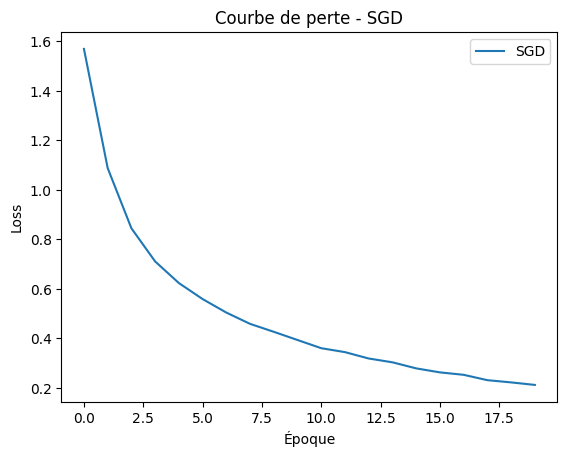

✅ Test Accuracy: 86.82%
📉 SGD - Précision : 86.82%
🕒 Temps total : 16.09 minutes
🧠 RAM utilisée : 3031.57 MB
🧠 GPU mémoire : 1503.00 MB (9.8%)
⚙️ GPU load : 91.0%


In [53]:
model_sgd = get_resnet18_with_checkpointing()
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

start_sgd = time.time()
losses_sgd = train(model_sgd, optimizer_sgd, trainloader, epochs=20)
plt.plot(losses_sgd, label="SGD")
plt.title("Courbe de perte - SGD")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.show()
acc_sgd = test(model_sgd, testloader)
ram_sgd, gpu_sgd, load_sgd = get_memory_usage()   # 💾 mémoire + GPU
std_sgd = np.std(losses_sgd)                      # 📉 stabilité
end_sgd = time.time()

print(f"📉 SGD - Précision : {acc_sgd:.2f}%")
print(f"🕒 Temps total : {(end_sgd - start_sgd)/60:.2f} minutes")
get_resource_usage()

📘 Epoch [1/20] - Loss: 1.3436
📘 Epoch [2/20] - Loss: 0.8744
📘 Epoch [3/20] - Loss: 0.6868
📘 Epoch [4/20] - Loss: 0.5717
📘 Epoch [5/20] - Loss: 0.5012
📘 Epoch [6/20] - Loss: 0.4444
📘 Epoch [7/20] - Loss: 0.4052
📘 Epoch [8/20] - Loss: 0.3622
📘 Epoch [9/20] - Loss: 0.3382
📘 Epoch [10/20] - Loss: 0.3035
📘 Epoch [11/20] - Loss: 0.2829
📘 Epoch [12/20] - Loss: 0.2648
📘 Epoch [13/20] - Loss: 0.2461
📘 Epoch [14/20] - Loss: 0.2275
📘 Epoch [15/20] - Loss: 0.2092
📘 Epoch [16/20] - Loss: 0.1960
📘 Epoch [17/20] - Loss: 0.1885
📘 Epoch [18/20] - Loss: 0.1707
📘 Epoch [19/20] - Loss: 0.1616
📘 Epoch [20/20] - Loss: 0.1468


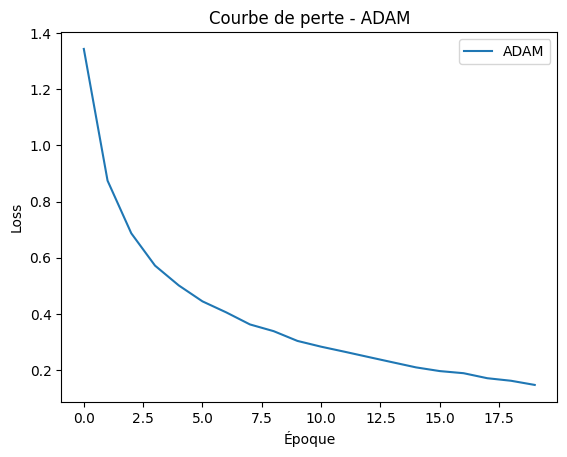

✅ Test Accuracy: 89.52%
📈 Adam - Précision : 89.52%
🕒 Temps total : 16.35 minutes
🧠 RAM utilisée : 3083.71 MB
🧠 GPU mémoire : 1755.00 MB (11.4%)
⚙️ GPU load : 78.0%


In [54]:
model_adam = get_resnet18_with_checkpointing()
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

start_adam = time.time()
losses_adam = train(model_adam, optimizer_adam, trainloader, epochs=20)
plt.plot(losses_adam, label="ADAM")
plt.title("Courbe de perte - ADAM")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.show()
acc_adam = test(model_adam, testloader)
ram_adam, gpu_adam, load_adam = get_memory_usage()
std_adam = np.std(losses_adam)

end_adam = time.time()

print(f"📈 Adam - Précision : {acc_adam:.2f}%")
print(f"🕒 Temps total : {(end_adam - start_adam)/60:.2f} minutes")
get_resource_usage()

Cloning into 'shampoo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 20.15 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.
📘 Epoch [1/20] - Loss: 1.8954
📘 Epoch [2/20] - Loss: 1.5233
📘 Epoch [3/20] - Loss: 1.3451
📘 Epoch [4/20] - Loss: 1.2063
📘 Epoch [5/20] - Loss: 1.0963
📘 Epoch [6/20] - Loss: 1.0039
📘 Epoch [7/20] - Loss: 0.9243
📘 Epoch [8/20] - Loss: 0.8583
📘 Epoch [9/20] - Loss: 0.7978
📘 Epoch [10/20] - Loss: 0.7455
📘 Epoch [11/20] - Loss: 0.6919
📘 Epoch [12/20] - Loss: 0.6452
📘 Epoch [13/20] - Loss: 0.6098
📘 Epoch [14/20] - Loss: 0.5729
📘 Epoch [15/20] - Loss: 0.5416
📘 Epoch [16/20] - Loss: 0.5138
📘 Epoch [17/20] - Loss: 0.4883
📘 Epoch [18/20] - Loss: 0.4667
📘 Epoch [19/20] - Loss: 0.4484
📘 Epoch [20/20] - Loss: 0.4307


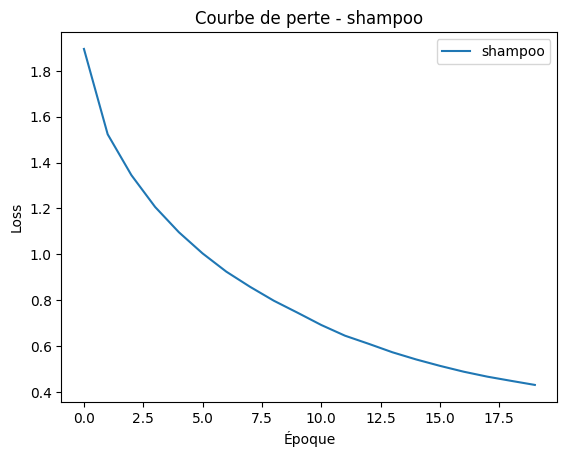

✅ Test Accuracy: 82.80%
🧴 Shampoo (optimisé) - Précision : 82.80%
🕒 Temps total : 48.01 minutes
🧠 RAM utilisée : 3374.11 MB
🧠 GPU mémoire : 2031.00 MB (13.2%)
⚙️ GPU load : 50.0%


In [55]:

!rm -rf shampoo  
!git clone https://github.com/SalmaSalama/shampoo.git

import sys
sys.path.append('/kaggle/working/shampoo/Shampoo')  

from shampoo_optimizer import Shampoo, ShampooHyperParams

# ✅ 2. Définir des hyperparamètres optimisés pour réduire la charge
hps = ShampooHyperParams(
    block_size=64,
    statistics_compute_steps=10,
    preconditioning_compute_steps=20,
    weight_decay=0.01,
    nesterov=True
)

# ✅ 3. Créer le modèle avec gradient checkpointing
model_shampoo = get_resnet18_with_checkpointing()

# ✅ 4. Optimiseur Shampoo avec les hyperparamètres
optimizer_shampoo = Shampoo(model_shampoo.parameters(), lr=0.001, momentum=0.9, hyperparams=hps)

# ✅ 5. Entraîner avec moins d’époques pour tester la stabilité
start_shampoo = time.time()
losses_shampoo = train(model_shampoo, optimizer_shampoo, trainloader, epochs=20)  
plt.plot(losses_shampoo, label="shampoo")
plt.title("Courbe de perte - shampoo")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc_shampoo = test(model_shampoo, testloader)
ram_shampoo, gpu_shampoo, load_shampoo = get_memory_usage()
std_shampoo = np.std(losses_shampoo)
end_shampoo = time.time()

# ✅ 6. Résultats
print(f"🧴 Shampoo (optimisé) - Précision : {acc_shampoo:.2f}%")
print(f"🕒 Temps total : {(end_shampoo - start_shampoo)/60:.2f} minutes")

get_resource_usage()


In [56]:
!rm -rf kfac-pytorch


In [57]:
!git clone https://github.com/gpauloski/kfac-pytorch.git

Cloning into 'kfac-pytorch'...
remote: Enumerating objects: 3526, done.
remote: Counting objects: 100% (786/786), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 3526 (delta 703), reused 656 (delta 656), pack-reused 2740 (from 2)
Receiving objects: 100% (3526/3526), 1010.81 KiB | 8.15 MiB/s, done.
Resolving deltas: 100% (2317/2317), done.


In [58]:
import sys
sys.path.append('/kaggle/working/kfac-pytorch')

In [59]:
file_path = "/kaggle/working/kfac-pytorch/kfac/__init__.py"

# Charger le contenu
with open(file_path, "r") as f:
    lines = f.readlines()

# Commenter la ligne qui contient importlib_metadata.version
with open(file_path, "w") as f:
    for line in lines:
        if "importlib_metadata.version" in line:
            f.write("# " + line)  # commenter
        else:
            f.write(line)

print("✅ Ligne __version__ désactivée avec succès !")


✅ Ligne __version__ désactivée avec succès !


/kaggle/working/kfac-pytorch/kfac/base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


📘 Epoch [1/20] - Loss: 1.5321
📘 Epoch [2/20] - Loss: 1.2366
📘 Epoch [3/20] - Loss: 1.3336
📘 Epoch [4/20] - Loss: 1.2979
📘 Epoch [5/20] - Loss: 1.1931
📘 Epoch [6/20] - Loss: 0.9643
📘 Epoch [7/20] - Loss: 0.8193
📘 Epoch [8/20] - Loss: 0.6864
📘 Epoch [9/20] - Loss: 0.5842
📘 Epoch [10/20] - Loss: 0.5321
📘 Epoch [11/20] - Loss: 0.4671
📘 Epoch [12/20] - Loss: 0.4209
📘 Epoch [13/20] - Loss: 0.3935
📘 Epoch [14/20] - Loss: 0.3696
📘 Epoch [15/20] - Loss: 0.3450
📘 Epoch [16/20] - Loss: 0.3142
📘 Epoch [17/20] - Loss: 0.2887
📘 Epoch [18/20] - Loss: 0.2763
📘 Epoch [19/20] - Loss: 0.2661
📘 Epoch [20/20] - Loss: 0.2388


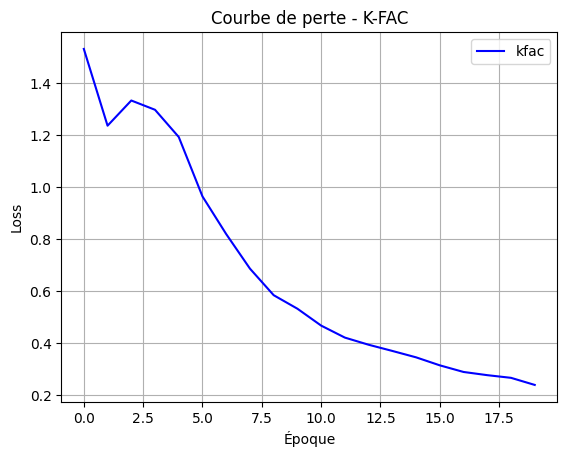

✅ Test Accuracy: 87.99%
📊 K-FAC - Précision : 87.99%
🕒 Temps total : 34.08 minutes
🧠 RAM utilisée : 3435.10 MB
🧠 GPU mémoire : 3771.00 MB (24.6%)
⚙️ GPU load : 86.0%


In [60]:
# 📥 1. Importer le préconditionneur K-FAC et l’optimiseur de base
from kfac.preconditioner import KFACPreconditioner
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# 🧠 2. Créer le modèle avec gradient checkpointing
model_kfac = get_resnet18_with_checkpointing()

# 🧪 3. Optimiseur de base (SGD requis par K-FAC)
base_optimizer = optim.SGD(model_kfac.parameters(), lr=0.01, momentum=0.9)

# ⚙️ 4. Optimiseur K-FAC configuré pour + stabilité et + vitesse
optimizer_kfac = KFACPreconditioner(
    model_kfac,
    factor_update_steps=10,         # fréquence mise à jour stats
    inv_update_steps=10,            # fréquence inversion
    damping=0.01,                   # stabilité num.
    factor_decay=0.95,
    kl_clip=0.001,
    lr=0.005,                       # taux d’apprentissage ajusté
    assignment_strategy='MEMORY',   # pour moins de calcul
    compute_method='INVERSE',       # plus rapide
    colocate_factors=True,
    allreduce_bucket_cap_mb=0,      # désactiver bucketing
    grad_worker_fraction=1.0,       # pas de distribution
    update_factors_in_hook=True,
    symmetry_aware=False,
    loglevel=40                     # silence
)

# 🚀 5. Entraînement + courbe de perte
start_kfac = time.time()
losses_kfac = train(
    model_kfac,
    base_optimizer,
    trainloader,
    epochs=20,
    preconditioner=optimizer_kfac
)
# 📉 6. Afficher la courbe de perte
plt.plot(losses_kfac, label="kfac", color="blue")
plt.title("Courbe de perte - K-FAC")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
acc_kfac = test(model_kfac, testloader)
ram_kfac, gpu_kfac, load_kfac = get_memory_usage()
std_kfac = np.std(losses_kfac)

end_kfac = time.time()


# ✅ 7. Évaluer la précision et afficher les ressources

print(f"📊 K-FAC - Précision : {acc_kfac:.2f}%")
print(f"🕒 Temps total : {(end_kfac - start_kfac)/60:.2f} minutes")

get_resource_usage()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


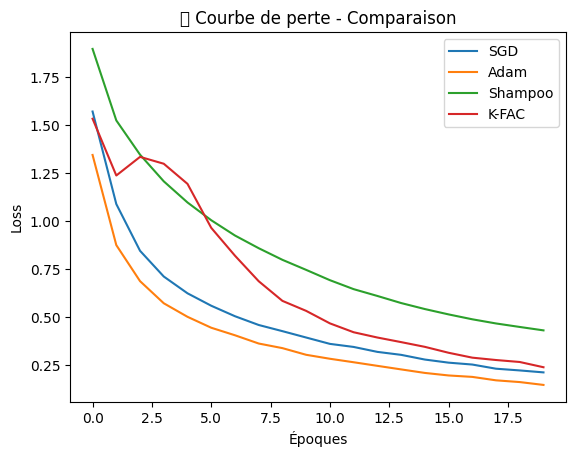

In [61]:
plt.plot(losses_sgd, label="SGD")
plt.plot(losses_adam, label="Adam")
plt.plot(losses_shampoo, label="Shampoo")
plt.plot(losses_kfac, label="K-FAC")
plt.title("📉 Courbe de perte - Comparaison")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [62]:
import pandas as pd

results = pd.DataFrame({
    "Optimiseur": ["SGD", "Adam", "Shampoo", "K-FAC"],
    "Accuracy (%)": [acc_sgd, acc_adam, acc_shampoo, acc_kfac],
    "Temps (min)": [
        round((end_sgd - start_sgd)/60, 2),
        round((end_adam - start_adam)/60, 2),
        round((end_shampoo - start_shampoo)/60, 2),
        round((end_kfac - start_kfac)/60, 2)
    ],
    "Stabilité (σ)": [std_sgd, std_adam, std_shampoo, std_kfac],
    "RAM (MB)": [ram_sgd, ram_adam, ram_shampoo, ram_kfac],
    "GPU Mem (MB)": [gpu_sgd, gpu_adam, gpu_shampoo, gpu_kfac],
    "Charge GPU (%)": [load_sgd, load_adam, load_shampoo, load_kfac]
})

display(results)


,Optimiseur,Accuracy (%),Temps (min),Stabilité (σ),RAM (MB),GPU Mem (MB),Charge GPU (%)
0,SGD,86.82,16.09,0.331996,3028.847656,1503.0,91.0
1,Adam,89.52,16.35,0.285960,3070.523438,1755.0,78.0
2,Shampoo,82.80,48.01,0.390146,3377.167969,2031.0,92.0
3,K-FAC,87.99,34.08,0.415843,3450.457031,3771.0,86.0


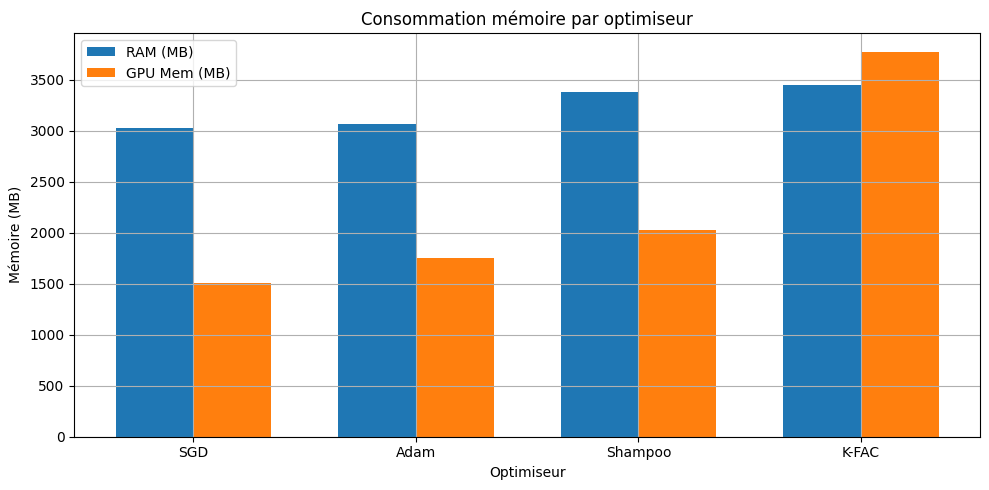

In [63]:
import matplotlib.pyplot as plt

bar_width = 0.35
index = range(len(results))

plt.figure(figsize=(10, 5))
plt.bar(index, results["RAM (MB)"], bar_width, label="RAM (MB)")
plt.bar([i + bar_width for i in index], results["GPU Mem (MB)"], bar_width, label="GPU Mem (MB)")

plt.xlabel("Optimiseur")
plt.ylabel("Mémoire (MB)")
plt.title("Consommation mémoire par optimiseur")
plt.xticks([i + bar_width / 2 for i in index], results["Optimiseur"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
